# Exploratory Data Analysis for Rho Dataset
The purpose of this notebook is to explore the rho dataset, particularly with respect to the PDG ID for which particles are decaying and how ATHENA keeps track of this
### TO DO:
1) Load rho dataset
2) Make histogram perhaps of PDG particle IDs
3) Explore tracking information and cluster size
4) Use visualization toolkit to make 3-D plots
    - End Cap Visualizations
    - Multiple Tracks, Multiple Clusters
    - Cluster/Track particle matching, color coded visualization using PDGID

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import uproot as ur
import awkward as ak
import time as t
import copy
import scipy.constants as spc
print("Awkward version: "+str(ak.__version__))
print("Uproot version: "+str(ur.__version__))

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/util/')
import deep_set_util as dsu

Awkward version: 1.4.0
Uproot version: 4.0.11


/fast_scratch/atlas_images/v01-45/rho/user.angerami.24409109.OutputStream._000001.root

In [15]:
from deep_set_util import track_branches, event_branches, np_event_branches,\
    geo_branches, ak_event_branches, np_event_branches

## Load Events

In [60]:
# for event dictionary
event_file_name = 'user.angerami.24409109.OutputStream._000001.root'
pipm_event_file_name = 'user.angerami.24559744.OutputStream._000001.root'

file_prefix = '/fast_scratch/atlas_images/v01-45/rho/'
pipm_file_prefix = '/fast_scratch/atlas_images/v01-45/pipm/'

rho_file = file_prefix+event_file_name
pipm_file = pipm_file_prefix+pipm_event_file_name

# Events
events = ur.open(rho_file)
pipm_events = ur.open(pipm_file)
events.keys()

['EventTree;1', 'CellGeo;1']

## Event Tree

In [61]:
event_tree = events['EventTree']
pipm_event_tree = pipm_events['EventTree']
event_tree.show(name_width=42,
                interpretation_width=60)

name                                       | typename                 | interpretation                                              
-------------------------------------------+--------------------------+-------------------------------------------------------------
runNumber                                  | int32_t                  | AsDtype('>i4')
eventNumber                                | int64_t                  | AsDtype('>i8')
lumiBlock                                  | int32_t                  | AsDtype('>i4')
coreFlags                                  | uint32_t                 | AsDtype('>u4')
mcEventNumber                              | int32_t                  | AsDtype('>i4')
mcChannelNumber                            | int32_t                  | AsDtype('>i4')
mcEventWeight                              | float                    | AsDtype('>f4')
nTruthPart                                 | int32_t                  | AsDtype('>i4')
G4PreCalo_n_EM                        

### Tracking Dictionary

In [17]:
track_dict = dsu.dict_from_tree(event_tree, branches=track_branches, np_branches=None)
pipm_track_dict = dsu.dict_from_tree(pipm_event_tree, branches=track_branches, np_branches=None)

### Event Dictionary

In [62]:
event_dict = dsu.dict_from_tree(event_tree, branches=ak_event_branches, np_branches=np_event_branches)
pipm_event_dict = dsu.dict_from_tree(pipm_event_tree, branches=ak_event_branches, np_branches=np_event_branches)
event_tree.show(name_width=42,
                interpretation_width=60)

name                                       | typename                 | interpretation                                              
-------------------------------------------+--------------------------+-------------------------------------------------------------
runNumber                                  | int32_t                  | AsDtype('>i4')
eventNumber                                | int64_t                  | AsDtype('>i8')
lumiBlock                                  | int32_t                  | AsDtype('>i4')
coreFlags                                  | uint32_t                 | AsDtype('>u4')
mcEventNumber                              | int32_t                  | AsDtype('>i4')
mcChannelNumber                            | int32_t                  | AsDtype('>i4')
mcEventWeight                              | float                    | AsDtype('>f4')
nTruthPart                                 | int32_t                  | AsDtype('>i4')
G4PreCalo_n_EM                        

### Geometry

In [33]:
## GEOMETRY DICTIONARY ##
geo_file = ur.open('/fast_scratch/atlas_images/v01-45/cell_geo.root')
CellGeo_tree = geo_file["CellGeo"]
geo_dict = dsu.dict_from_tree(tree=CellGeo_tree, branches=None, np_branches=geo_branches)

# cell geometry data
cell_geo_ID = geo_dict['cell_geo_ID']
cell_ID_dict = dict(zip(cell_geo_ID, np.arange(len(cell_geo_ID))))

# additional geometry data
layer_rPerp = np.array([1540., 1733., 1930., 2450., 3010., 3630.])
track_sample_layer = np.array([1,2,3,12,13,14])

# Display Stuff
CellGeo_tree.show(interpretation_width=60)

name                 | typename                 | interpretation                                              
---------------------+--------------------------+-------------------------------------------------------------
cell_geo_ID          | std::vector<uint64_t>    | AsJagged(AsDtype('>u8'), header_bytes=10)
cell_geo_sampling    | std::vector<uint16_t>    | AsJagged(AsDtype('>u2'), header_bytes=10)
cell_geo_eta         | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_phi         | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_rPerp       | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_deta        | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_dphi        | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_volume      | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_sigma       | std::vector<float> 

## Preliminary Histograms

In [34]:
N_evts = len(event_dict['eventNumber'])
print('Number of events: '+str(N_evts))

Number of events: 20000


## General Information
#### Particle Number (PdgID)
#### Number of Tracks
#### Average Total Number of points

In [63]:
truthParticleID = np.empty(N_evts, dtype=object)
numTracks = np.empty(N_evts, dtype=np.int32)
pipm_numTracks = np.empty(N_evts, dtype=np.int32)
tot_numPoints = np.empty(N_evts, dtype=np.int32)
pipm_tot_numPoints = np.empty(N_evts, dtype=np.int32)

# Flatten the truth particle ID to make one giant histogram
truthPdgId = ak.flatten(event_dict['truthPartPdgId'])
pipm_truthPdgId = ak.flatten(pipm_event_dict['truthPartPdgId'])
truthParticleFlat = np.empty(len(truthPdgId))
pipmtruthParticleFlat = np.empty(len(truthPdgId))

for i in range(N_evts):
    
    # Find total number of points in the point cloud
    nClusters = event_dict['nCluster'][i]
    nPts = 0
    for j in range(nClusters):
        nPts += len(event_dict['cluster_cell_ID'][i][j])
    tot_numPoints[i] = nPts
    
    # Find total number of points in the point cloud for pipm 
    pipm_nClusters = pipm_event_dict['nCluster'][i]
    pipm_nPts = 0
    for j in range(pipm_nClusters):
        pipm_nPts += len(pipm_event_dict['cluster_cell_ID'][i][j])
    pipm_tot_numPoints[i] = pipm_nPts
    
    # total number of tracks
    numTracks[i] = event_dict['nTrack'][i]
    
    # total number of tracks
    pipm_numTracks[i] = pipm_event_dict['nTrack'][i]

### Plotting

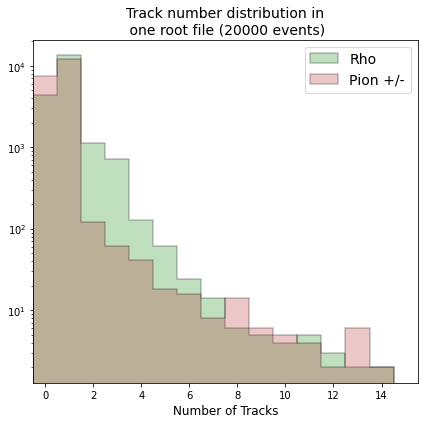

In [69]:
fig = plt.figure(figsize=(6,6))

bin_list = np.arange(-.5,15.5,1)
plt.hist(numTracks, bins=bin_list, color='green', edgecolor='black', alpha=.25, linewidth=1.5,
         histtype='stepfilled', label='Rho')
plt.hist(pipm_numTracks, bins=bin_list, color='firebrick', edgecolor='black', alpha=.25, linewidth=1.5,
         histtype='stepfilled', label='Pion +/-')
plt.yscale('log')
plt.xlim(-.5,15.5)
plt.title('Track number distribution in\n one root file (20000 events)', fontsize=14)
plt.xlabel('Number of Tracks', fontsize=12)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()
# plt.savefig('EDA_Plots/Track_Hist.png', format='png')
plt.show()

<Figure size 432x288 with 0 Axes>

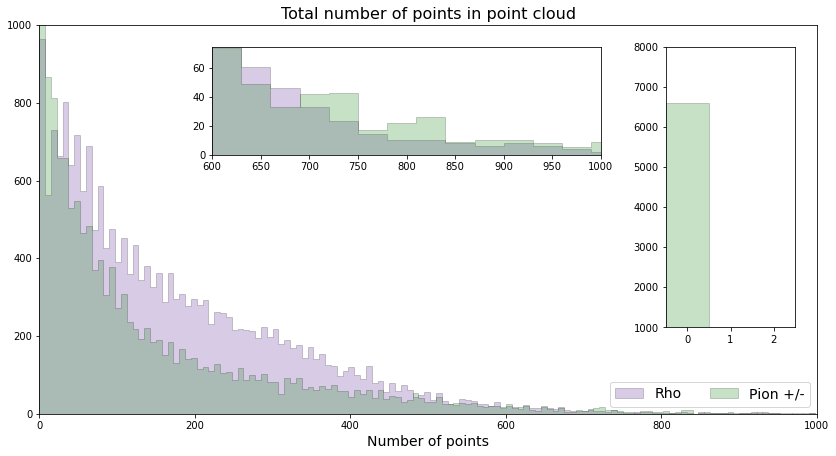

In [118]:
plt.clf()
fig = plt.figure(figsize=(12,6))

bin_list = np.arange(0,1005,7.5)

ax1 = fig.add_axes([.05,.05,.9,.9])
ax2 = fig.add_axes([.775,.25,.15,.65])
ax3 = fig.add_axes([.25,.25+.65-.25,.45,.25])

ax1.hist(tot_numPoints, bins=bin_list, color='rebeccapurple', edgecolor='black', alpha=.25, linewidth=.75,
        histtype='stepfilled', label='Rho')
ax1.hist(pipm_tot_numPoints, bins=bin_list, color='forestgreen', edgecolor='black', alpha=.25, linewidth=.75,
         histtype='stepfilled', label='Pion +/-')
# plt.yscale('log')
ax1.set_xlim(0,1000)
ax1.set_title('Total number of points in point cloud', fontsize=16)
ax1.set_xlabel('Number of points', fontsize=14)
ax1.set_ylim(0,1000)
ax1.legend(loc='lower right', ncol=2, prop={'size':14})

ax2.hist(pipm_tot_numPoints, bins=np.arange(-.5,3.5,1), color='forestgreen', edgecolor='black', alpha=.25, linewidth=.75,
         histtype='stepfilled', label='Pion +/-')
ax2.set_xlim(-.5,2.5)
ax2.set_ylim(1000,8000)
ax2.xaxis.set_major_locator(plt.MultipleLocator(1))

ax3.hist(tot_numPoints, bins=np.arange(600,1030,30), color='rebeccapurple', edgecolor='black', alpha=.25, linewidth=.75,
        histtype='stepfilled', label='Rho')
ax3.hist(pipm_tot_numPoints, bins=np.arange(600,1030,30), color='forestgreen', edgecolor='black', alpha=.25, linewidth=.75,
         histtype='stepfilled', label='Pion +/-')
ax3.set_xlim(600,1000)
ax3.set_ylim(0,75)

# plt.savefig('EDA_Plots/Rho_num_in_pointcloud2.png', format='png')
plt.show()